In [1]:
import pandas as pd
import glob

# Please change the path accordingly
files = glob.glob('C:/Users/Dell/Desktop/DHIS (APRIL 15-MARCH 16)/**/*.xls', recursive=True)

frames = {}

#  Iterate over excel_files
for file in files:
    
    # Using the facility name as a key in a dictionary
    key = pd.read_excel(file, usecols=[2]).columns.format()[0].strip()
    
    #  Read xlsx into a DataFrame
    df = pd.read_excel(file, skiprows=7, index_col=[0,1], usecols=list(range(2, 17))).dropna()
    
    df = df.transpose()

    # Append df to frames
    frames.update({key: df})

unified_data = pd.concat(frames)
unified_data.columns.names = [None, None]
unified_data.to_csv('unified_data.csv')

In [2]:
from collections import Counter

# Extract names of all health centers
faci = unified_data.index.get_level_values(0).unique()

nz_col_list = []

for f in faci:
    
    # Extract all the metrics where 'Total' column (column at the end of time periods) is not zero in a particular health center
    nz_col = list(unified_data.loc[f].loc['Total', unified_data.loc[f, 'Total'] != 0].index.get_level_values(0).unique())
    
    # Create a list of all metrics extracted above from different health centers
    nz_col_list.extend(nz_col)

# Count how often does a metric occur in the above list
nz_col_counts = Counter(nz_col_list)

In [3]:
nz_col_counts.most_common(15)

[('Number of pregnant women received 3 ANC check ups', 374),
 ('Number having Hb level<11 (tested cases)', 374),
 ('Female', 374),
 ('Total {(a) to (b)}', 374),
 ('Children more than 5 years given DT5', 374),
 ('Planned', 374),
 ('Held', 374),
 ('Dose-1', 374),
 ('Total number of pregnant women Registered for ANC  ', 373),
 ('Of which Number registered within first trimester', 373),
 ('TT2 or Booster', 373),
 ('DPT2', 373),
 ('OPV2', 373),
 ('OPV3', 373),
 ('Hepatitis-B2', 373)]

In the excel files, there were many metrics where all the values (or their total values) were zero, whcih won't be ueful in determining if the numbers follow the vertical hierarchy of levels (Levels of health centers), so names of all the metrics whose total values (value in 'Total' column of each metric) were not zero were extracted with the number of times the total value is not zero, above displayed is the most frequent metrics whose total value is not zero with their frequency, from this list four metrics were taken for answering the question (if the numbers follow the vertical hierarchy of levels), 2 metrics pertain to infants and other 2 to pregnant women as these are the two sections which are most vulnerable to contracting diseases, more and different metrics can be used to answer the above question, but there is no objective way of deciding of which and how many metrics  

In [4]:
# List of four metrics to be used to check if the numbers follow the vertical hierarchy of levels (Levels of health centers)
metrics_list = [nz_col_counts.most_common(30)[0][0], nz_col_counts.most_common(30)[8][0], nz_col_counts.most_common(30)[11][0], nz_col_counts.most_common(30)[12][0]]

# List of levels of health centers
faci_divisions = ['SC', 'PHC', 'RH ']

metrics_div = {}
metrics_mean_div = {}
for div in faci_divisions:
    
    # Find all health centers at a particular level
    hc_div = list(faci[faci.str.contains(div)])
    
    # Compute the sum of a metric of all health centers at a particular level
    metrics_div[div] = unified_data.loc[hc_div, metrics_list].xs('Total', level=1).sum().values
    
    # Compute the mean of a metric of all health centers at a particular level
    metrics_mean_div[div] = unified_data.loc[hc_div, metrics_list].xs('Total', level=1).sum().values/len(hc_div)

metrics_div

{'PHC': array([29407., 28603., 20599., 26625.]),
 'RH ': array([1704., 2192., 1607., 1680.]),
 'SC': array([26622., 25702., 18054., 23330.])}

In [5]:
metrics_mean_div

{'PHC': array([600.14285714, 583.73469388, 420.3877551 , 543.36734694]),
 'RH ': array([189.33333333, 243.55555556, 178.55555556, 186.66666667]),
 'SC': array([84.24683544, 81.33544304, 57.13291139, 73.82911392])}

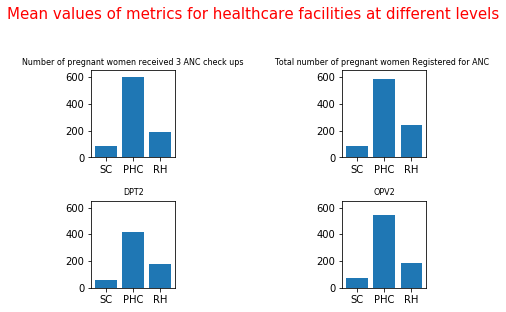

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.bar(range(len(metrics_mean_div)), [metrics_mean_div['SC'][i], metrics_mean_div['PHC'][i], metrics_mean_div['RH '][i]])
    plt.xticks(range(len(metrics_mean_div)), ['SC', 'PHC', 'RH'])
    plt.title(metrics_list[i], fontsize=8)
    plt.ylim([0, 650])

plt.subplots_adjust(wspace=2, hspace=0.5)
plt.suptitle('Mean values of metrics for healthcare facilities at different levels', y=1.1, fontsize=15, color='red')
plt.savefig('Mean values of metrics for healthcare facilities at different levels.png',  bbox_inches='tight')

In the plot above and below, we can see that health metrics do not follow vertical hierarchy of the divisional health centers,
but we can observe a pattern that PHC metrics are greater than SC and RH metrics, this seems true as PHC's serve more people 
than both SC and RH, SC's serve smaller population and also are only equipped to handle trivial cases whereas people go to RH 
only when the case is pretty complex and referred by PHC

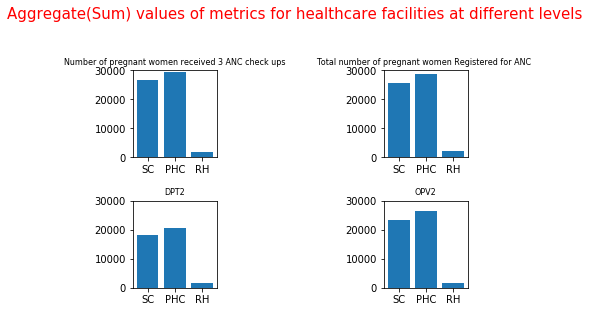

In [7]:
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.bar(range(len(metrics_div)), [metrics_div['SC'][i], metrics_div['PHC'][i], metrics_div['RH '][i]])
    plt.xticks(range(len(metrics_div)), ['SC', 'PHC', 'RH'])
    plt.title(metrics_list[i], fontsize=8)
    plt.ylim([0, 30000])

plt.subplots_adjust(wspace=2, hspace=0.5)
plt.suptitle('Aggregate(Sum) values of metrics for healthcare facilities at different levels', y=1.1, fontsize=15, color='red')
plt.savefig('Aggregate(Sum) values of metrics for healthcare facilities at different levels.png',  bbox_inches='tight')

Please observe that in the plots above, in plot with mean values RH is greater than SC for all metrics and in plot with summation values SC is greater than RH for all metrics, this is due to the fact that there are many SC's and very few RH's, that's why when we use summed up values SC is greater than RH, also fewer people visit SC (due to lack of proper services there) than RH, that's why when mean values are used RH is greater than SC

In [8]:
import numpy as np

# Function to visualize different health trends
def health_trends(numerator, denominator, y_axis_name, facility_levels=faci_divisions, facilities=faci, kind='bar', rate_number=1, ymax=1, plot_title=None):
    
    # All of the health trends shown below are some form of division between different metrics, in that context 
    # two parameters 'numerator' and 'denominator' have been used
    # y_axis_name : Label of y-axis in plot
    # facility_levels : Levels of health centers
    # facilities : Names of all health centers
    # kind : type of plot
    # rate_number : this number can be used to calculate fraction (1), percentage (100), rate per 1000 (1000) etc.
    # ymax : Maximum value of y-axis in plot
    # plot_title : Title of plot
    
    trend_div = {}
    trend_div_mean = {}
    col_name = y_axis_name
    trend_div_df = pd.DataFrame()
    
    if not plot_title:
            plot_title = numerator
    if len(col_name) >= 48:
            y_axis_name = col_name[:48] + ' \n ' + col_name[48:]
            
    for facility_level in facility_levels:
        
        # Find all health centers at a particular level
        hc_div = list(facilities[facilities.str.contains(facility_level)])
        
        # Compute the new metric
        trend_div[facility_level] = (unified_data.loc[hc_div, numerator].astype(float) * rate_number).divide(unified_data.loc[hc_div, denominator].astype(float))
        trend_div[facility_level].columns = [col_name]    
        
        # Replace all infinity values by NaN
        trend_div[facility_level][trend_div[facility_level][col_name] == np.inf] = np.nan
        
        # Calculate mean of new metric on different levels of health centers
        trend_div_mean[facility_level] = trend_div[facility_level].mean(level=1)
        
        title = plot_title + ' ' + facility_level
        ax = trend_div_mean[facility_level].plot(kind=kind, legend=False, figsize = (10,5))
        ax.set_ylim([0, ymax])
        ax.set_xlabel('Time period')
        ax.set_ylabel(y_axis_name)
        ax.set_title(label=title, color = 'red', fontsize = 22)
        ax.figure.savefig(title + '.png', bbox_inches='tight')
        trend_div_df = trend_div_df.append(trend_div[facility_level])        
    
    trend_div_df.to_csv(plot_title + '.csv')

Please keep in mind that all the values used in all the health trends shown below are mean values.

Indiaspend reported in 2016 that rate of stillbirths decreased per 1,000 births in India is 23 as compared to world's 18.4 [1], according to our data, in Nagpur district we found out that for most of the time in SC's and PHC's (both showing one instance each when SC is closer to world's stillbirth rate and PHC is greater than both world's and India's stillbirth rate) still birth rate is lower than that of world's, but in case of RH there are four instances when stillbirth rate is higher than world's and lower than India's, when we look further into the 3 plots (SC, PHC, RH) we can see that time periods of high stillbirth rate are not coinciding, that means there was no district wide phenomena rather there could be local factors due to which stillbirth rate increased like lack of timely and quality antenatal monitoring (please refer to [1] to know about more potential reasons for stillbirths), patient data would be needed to find out if there is any common reason for the rise in stillbirt rate.

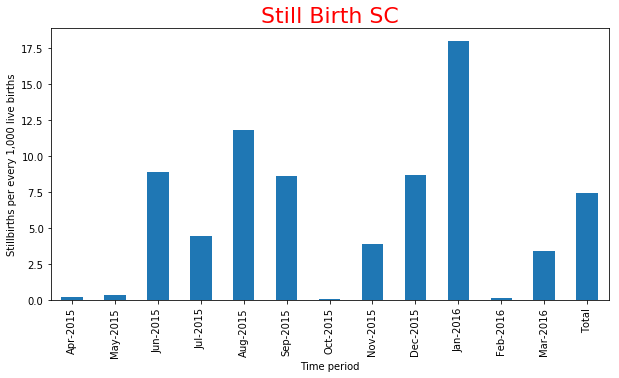

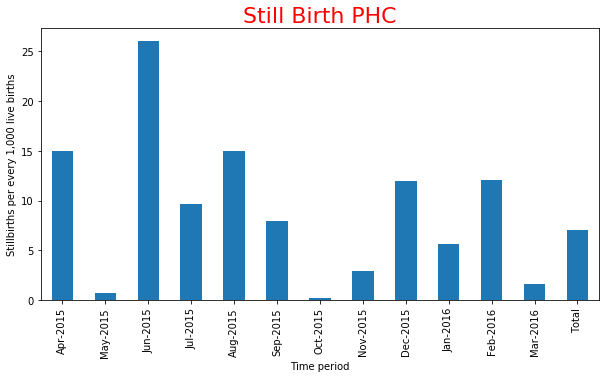

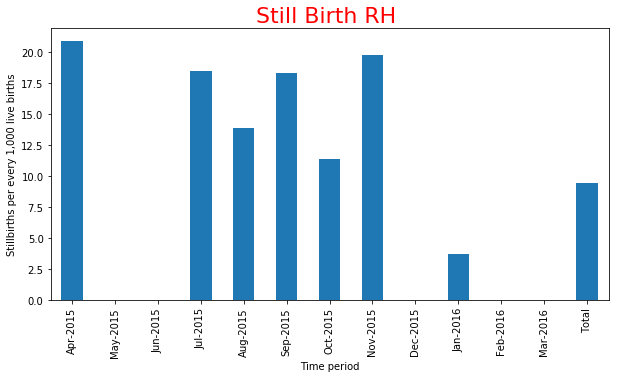

In [9]:
health_trends('Still Birth', 'Total ({a} + {b})', y_axis_name = 'Stillbirths per every 1,000 live births', rate_number=1000, ymax=None)

National Family Health Survey(NFHS) 2015-16 [2] reported that many people suffered from anemia in India, for example in Maharashtra 53.8 % children aged 6-59 months, 47.9 % non-pregnant women aged 15-49 years, 49.3 % pregnant women aged 15-49 years, 17.6 % men aged 15-49 years were anemic, these figures are slightly lower than national figures.

In plots below we can observe that highest % of anemic cases took place at SC level in December 2015 (slightly greater than 20 %), now the problem is this metric in our data is not classified into different categories like NFHS has, so we cannot directly compare our numbers, still the difference is so much that we can safely say that Nagpur district has done very well in reducing anemic cases, it is much much better than state and national level.

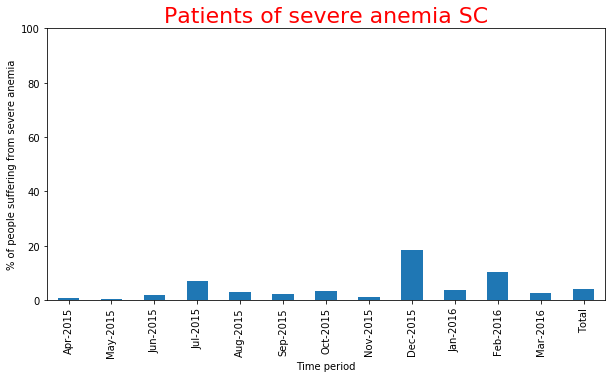

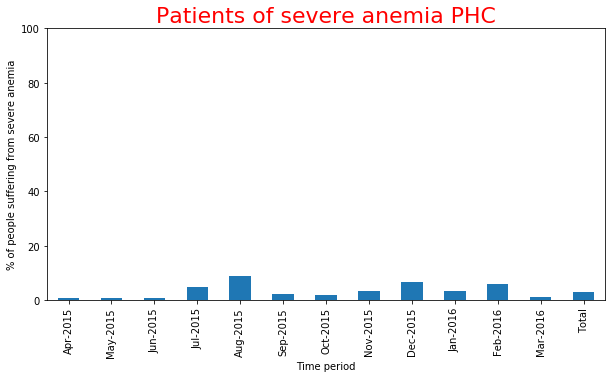

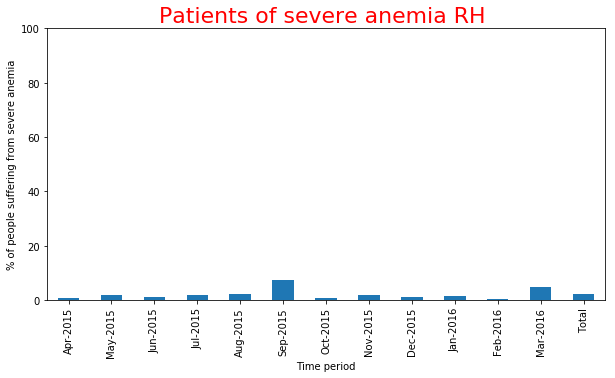

In [10]:
health_trends('Of which number having Hb < 7 mg', 'Number of Hb tests conducted', y_axis_name='% of people suffering from severe anemia', plot_title='Patients of severe anemia', rate_number=100, ymax=100)

According to a 2016 report of WHO [3], 0.08 % population of India suffers from malaria, 66 % of these are due to Plasmodium Falciparum and 34 % due to Plasmodium Vivax, below plots show that same is the case in Nagpur district where % of patients of malaria (either due to Plasmodium Falciparum or due to Plasmodium Vivax) are negligible.

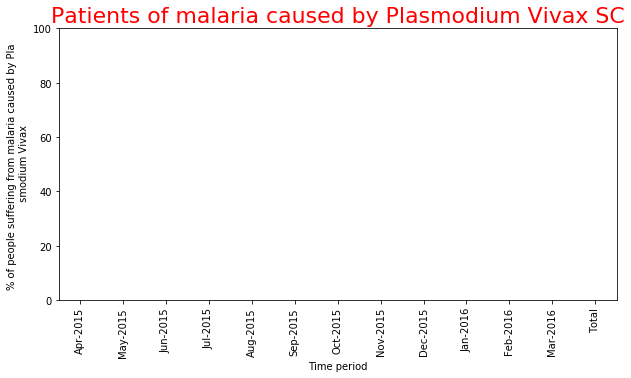

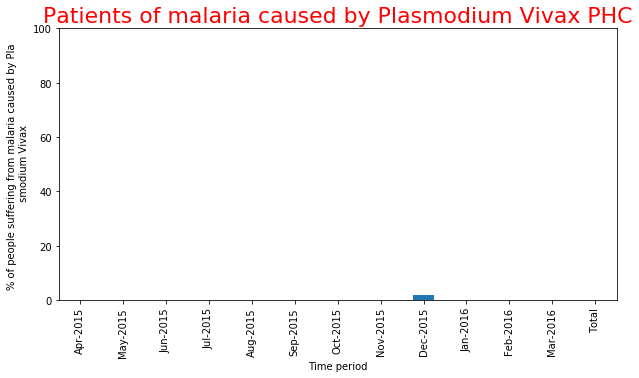

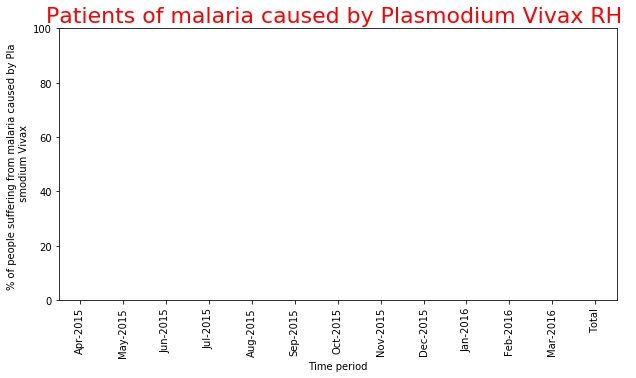

In [11]:
health_trends('Plasmodium Vivax test positive', 'Blood smears examined', y_axis_name='% of people suffering from malaria caused by Plasmodium Vivax', plot_title='Patients of malaria caused by Plasmodium Vivax', rate_number=100, ymax=100)

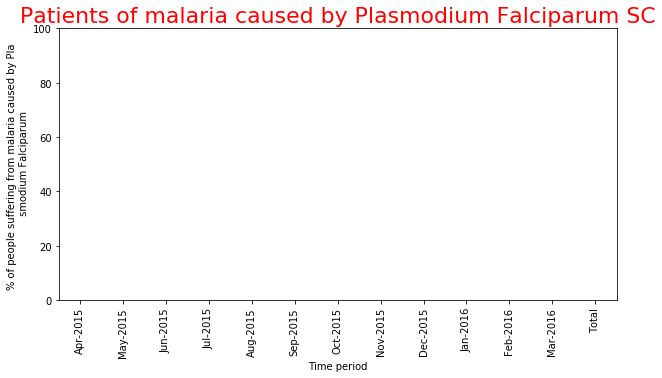

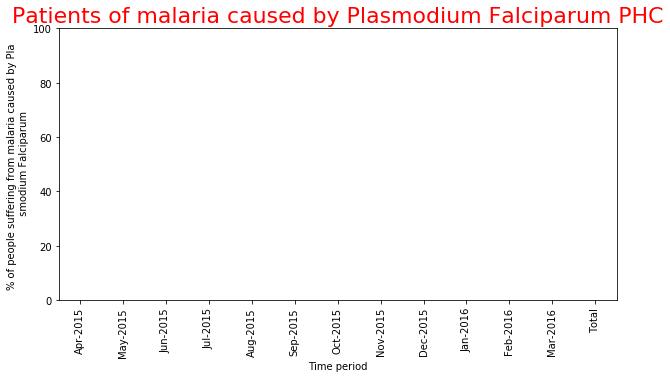

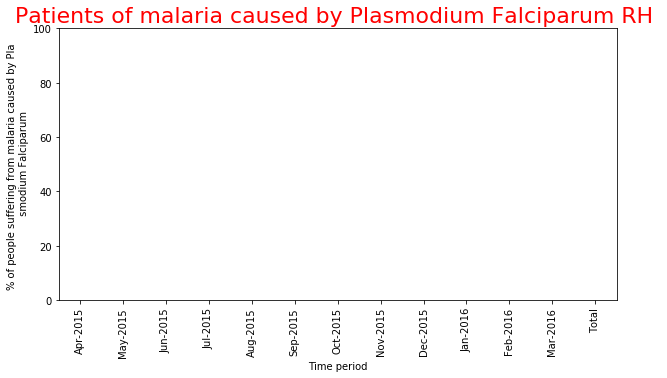

In [12]:
health_trends('Plasmodium Falciparum test positive', 'Blood smears examined', y_axis_name='% of people suffering from malaria caused by Plasmodium Falciparum', plot_title='Patients of malaria caused by Plasmodium Falciparum', rate_number=100, ymax=100)

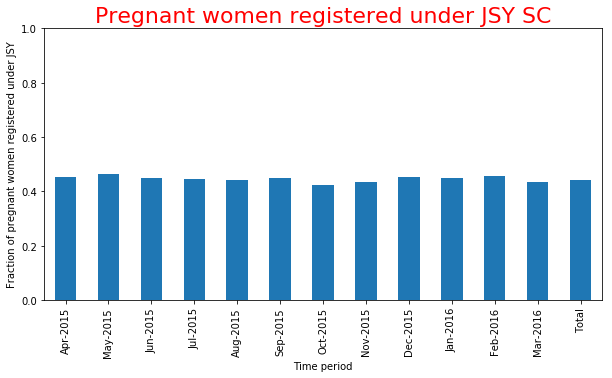

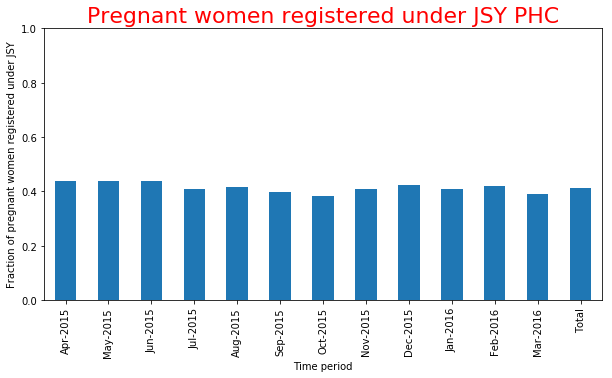

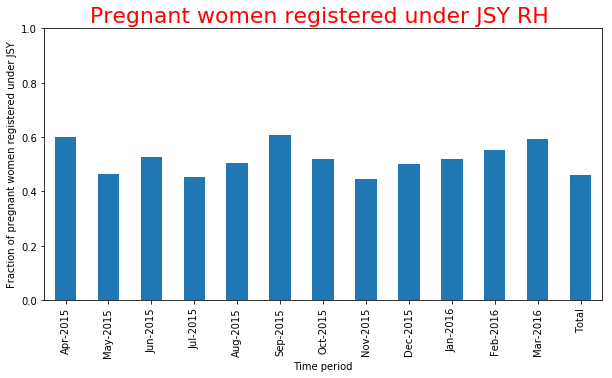

In [13]:
health_trends('New women registered under JSY', 'Total number of pregnant women Registered for ANC  ', y_axis_name='Fraction of pregnant women registered under JSY', plot_title='Pregnant women registered under JSY')

According to [4], first 48 hours of the post-partum period, followed by the first one week, are the most crucial period for the health and survival of both mother and her newborn. 

National Family Health Survey(NFHS) 2015-16 [2] reported that 78.5 % mothers in Maharashtra received post-partum care within 48 hours of delivery. In the plots below, our data shows that in Nagpur district SC's and PHC's this % is low (nearly 50 % and 55 % respectively) and consistent across time periods. In case of RH also, % is low, less than 70 %, but it is inconsistent across time periods, April to June 2015 is fine, in July 2015 % drops and remains low till Feb 2016, in March 2016 % is above 80.

So more awareness needs to be spread in Nagpur district regarding post-partum care.

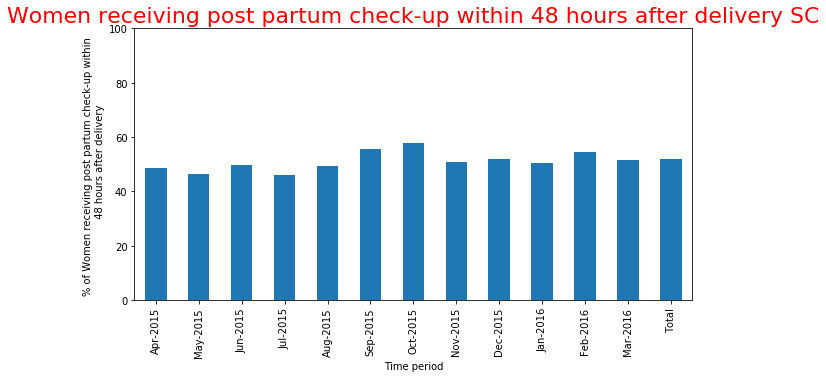

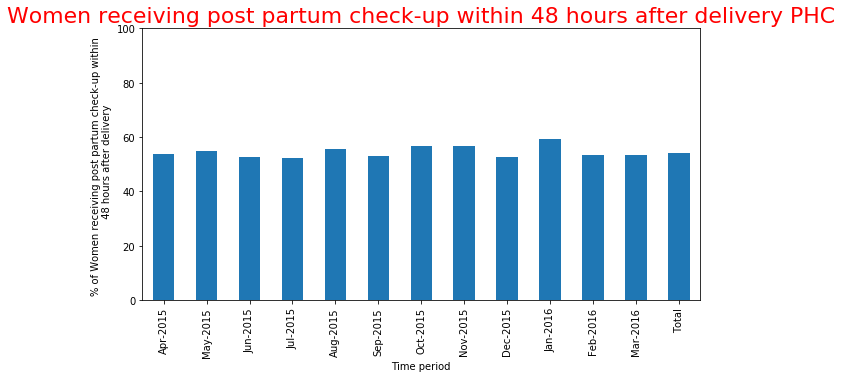

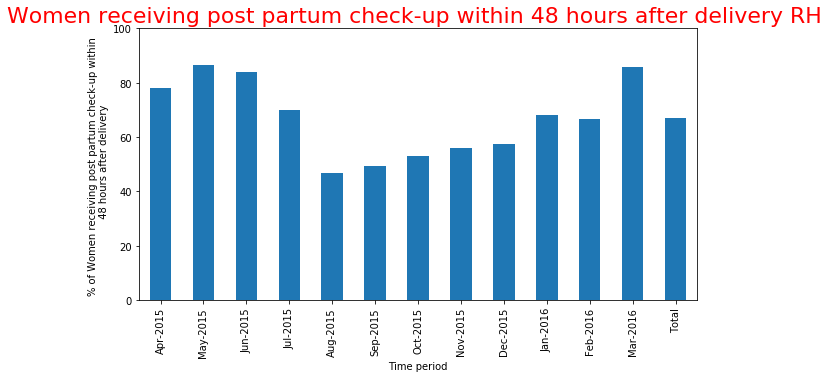

In [14]:
health_trends('Women receiving post partum check-up within 48 hours after delivery', 'Total ({a} + {b})', y_axis_name='% of Women receiving post partum check-up within 48 hours after delivery', plot_title='Women receiving post partum check-up within 48 hours after delivery', rate_number=100, ymax=100)

According to WHO recommendations [5], newborns should be breast fed within one hour of birth as it ensures that the infant receives the colostrum, or 'first milk', which is rich in protective factors.

According to [2], 57.5 % of newborns in Maharashtra and 41.6 % in whole India were breast fed within one hour of birth, compared to this, Nagpur district's performance has been exemplary, at all levels (SC, PHC, RH) it is above 95 % (look at the plots below).

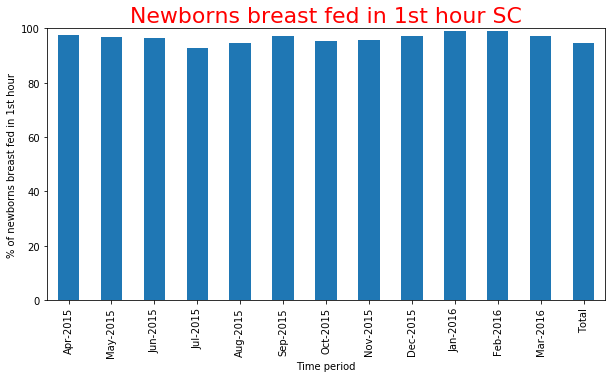

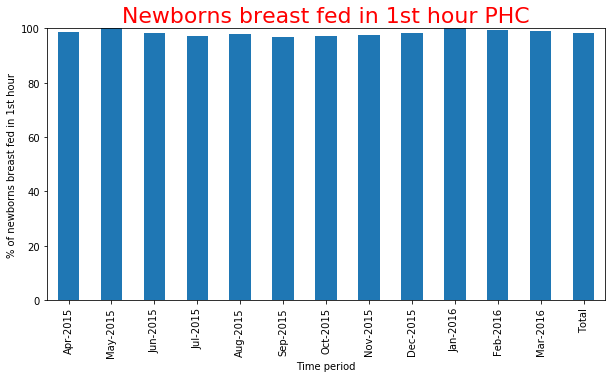

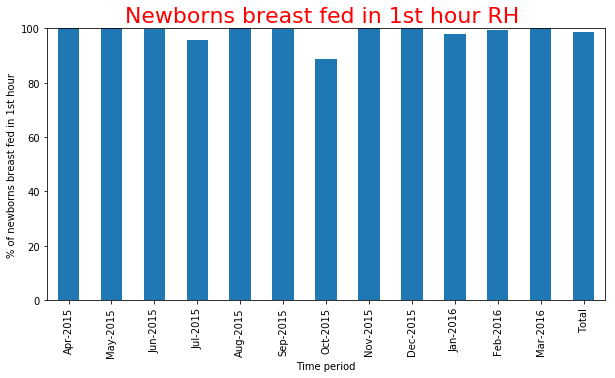

In [15]:
health_trends('Number of Newborns breast fed within 1 hour', 'Total ({a} + {b})', y_axis_name='% of newborns breast fed in 1st hour', plot_title='Newborns breast fed in 1st hour', rate_number=100, ymax=100)

Indiaspend reported in November 2016 that 28 % of newborns in India have weight less than 2.5 kgs (lbw also called low birth weight) [6], this can even lead to infant's death and 48.1 % infants died before they completed 29 days post-birth weighed less than 2.5 kgs [6].

According to plots below, in SC's and PHC's of Nagpur district around 15 % newborns were of lbw, in RH this % is slightly greater than 20, although this is less than national figure, however, it needs to be much lower, this condition is generally caused by poor nutrition during pregnancy [6], more awareness needs to be spread about pre-natal care.

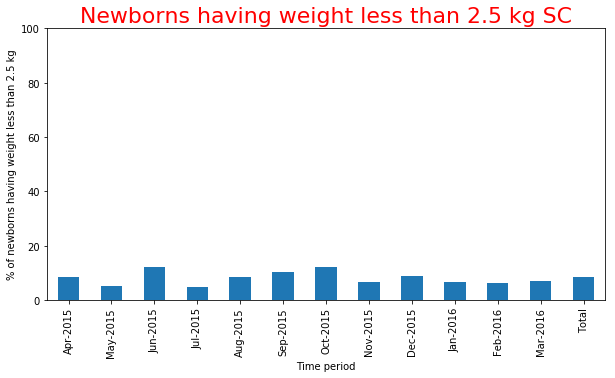

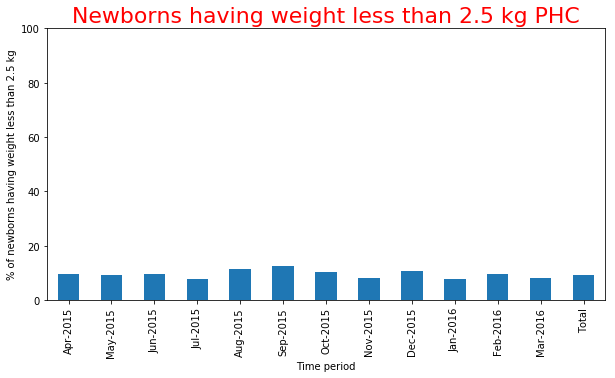

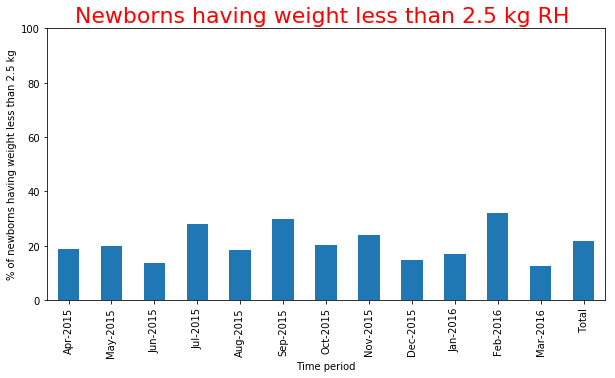

In [16]:
health_trends('Number of Newborns having weight less than 2.5 kg', 'Total ({a} + {b})', y_axis_name='% of newborns having weight less than 2.5 kg', plot_title='Newborns having weight less than 2.5 kg', rate_number=100, ymax=100)

According to [7], discharge at any time ≤ 48 hours significantly increases the risk for readmission, so it should be avoided.

On this front, Nagpur distrct does well, % of women taking early discharge is pretty low at all levels (a bit high in RH due to spike in October 2015 and Jan 2016). 

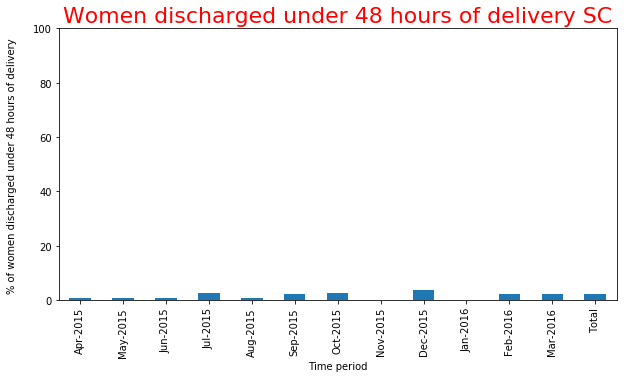

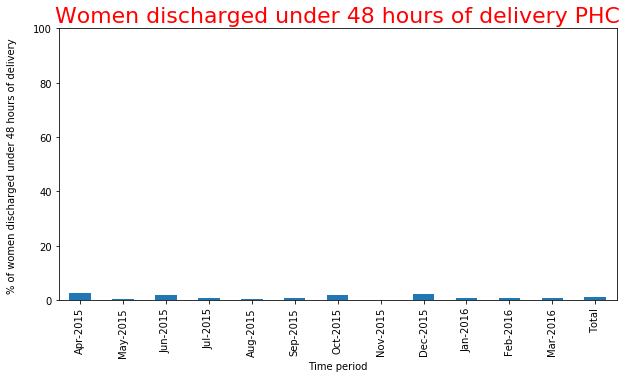

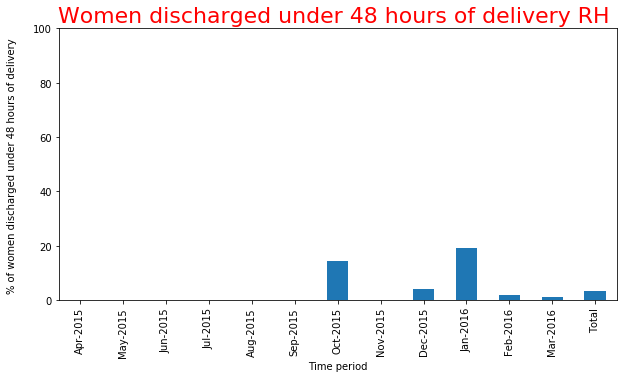

In [17]:
health_trends('Of which Number discharged under 48 hours of delivery', 'Deliveries conducted at Public Institutions ', y_axis_name='% of women discharged under 48 hours of delivery', plot_title='Women discharged under 48 hours of delivery', rate_number=100, ymax=100)

National Family Health Survey(NFHS) 2015-16 [2] reported that 67.6 % mothers in Maharashtra had antenatal check-up in the first trimester, national figure is 58.6 %. In the plots below, our data shows that in Nagpur district SC's and PHC's this % is better (nearly 80 % in both) and consistent across time periods. In case of RH, not only is % low (around 65 %) but also it is inconsistent across time periods.

So more awareness needs to be spread in Nagpur district (specially at RH level) regarding antenatal care.

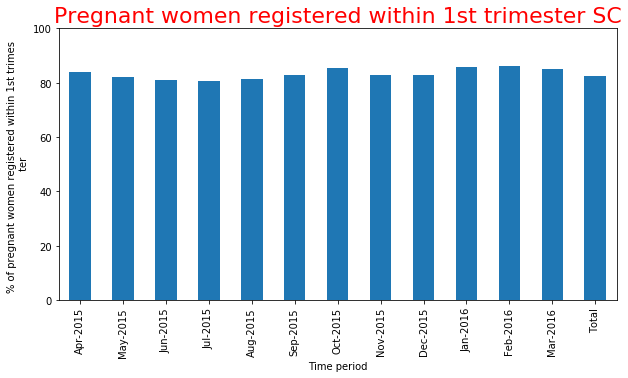

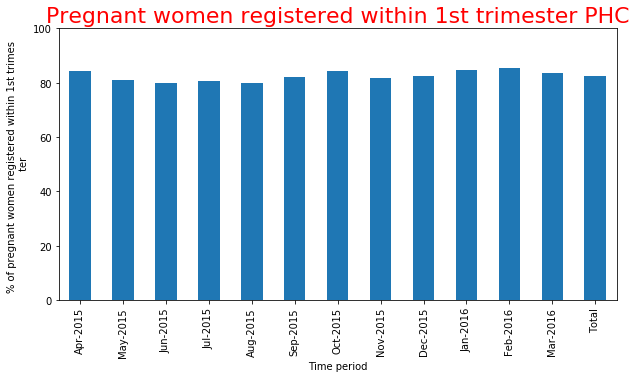

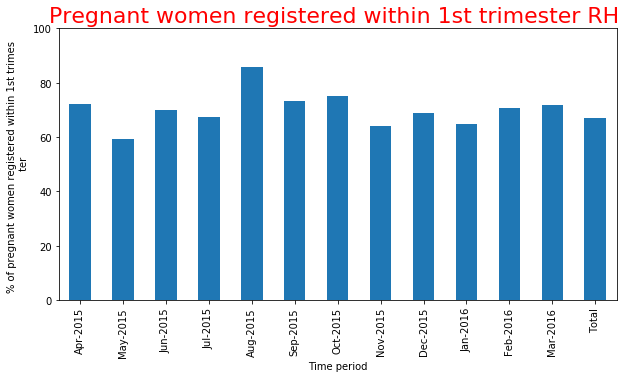

In [18]:
health_trends('Of which Number registered within first trimester', 'Total number of pregnant women Registered for ANC  ', y_axis_name='% of pregnant women registered within 1st trimester', plot_title='Pregnant women registered within 1st trimester', rate_number=100, ymax=100)

References

1. http://archive.indiaspend.com/cover-story/why-india-has-worlds-most-stillborn-babies-73270
2. http://rchiips.org/NFHS/factsheet_NFHS-4.shtml
3. http://www.who.int/entity/malaria/publications/country-profiles/profile_ind_en.pdf?ua=1
4. http://vikaspedia.in/health/women-health/pregnancy-health-1/checklist-for-post-natal-check-up
5. http://www.who.int/elena/titles/early_breastfeeding/en/
6. http://archive.indiaspend.com/cover-story/low-birth-weight-preterm-delivery-cause-most-newborn-deaths-in-india-45376
7. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3336902/